# Project Vetor II - UEL - Hypothetical flight
The Vetor II Project began in 2022 at UEL and, although it hasn't conducted a real flight yet, it includes a motor, a functional test bench, and a complete vehicle structure.

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np

from rocketpy import Environment, Flight, Function, Rocket, SolidMotor

In [53]:
plt.style.use("seaborn-v0_8-dark-palette")

## RocketPy Simulation


### Environment


Define the `Environment` object

(Location: Londrina, Brazil)

In [54]:
# Environment conditions
env = Environment(
    gravity=9.81,
    latitude=-23.245282518586297,
    longitude=-51.232450098784994,
    date=(2024, 12, 1, 13),
    timezone="America/Sao_Paulo",
    elevation=580,
)

env.max_expected_height = 2000

Visualize the `Environment` object



Gravity Details

Acceleration of gravity at surface level:    9.8100 m/s²
Acceleration of gravity at   2.000 km (ASL): 9.8100 m/s²


Launch Site Details

Launch Date: 2024-12-01 16:00:00 UTC | 2024-12-01 13:00:00 America/Sao_Paulo
Launch Site Latitude: -23.24528°
Launch Site Longitude: -51.23245°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 476221.37 W    7429308.07 S
Launch Site UTM zone: 22K
Launch Site Surface Elevation: 580.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 2.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 945.70 hPa
Surface Temperature: 284.39 K
Surface Air Density: 1.158 kg/m³
Surface Speed of Sound: 337.91 m/s


Earth Model Details

Earth Radius at Launch site: 6374.83 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



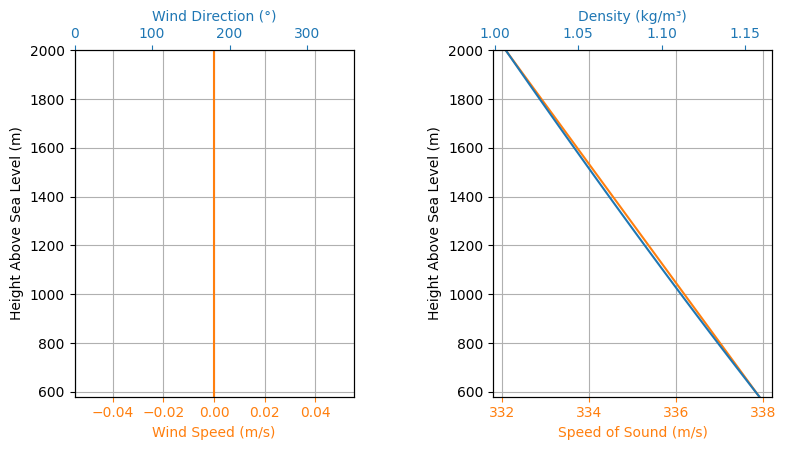

In [55]:
env.info()

### Motor


Define the `SolidMotor` object with real test bench data


In [56]:
m300 = SolidMotor(
    thrust_source="../../data/motors/vetor_ii/vetor_ii_thrust_curve.csv",
    burn_time=1.8,
    dry_mass=0.4938,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=0.160 / 2,
    grains_center_of_mass_position=0.160 / 2,
    grain_number=1,
    grain_separation=0,
    grain_density=1730,
    grain_outer_radius=0.044 / 2,
    grain_initial_inner_radius=0.00725 / 2,
    grain_initial_height=0.125,
    nozzle_radius=0.020 / 2,
    throat_radius=0.010 / 2,
)

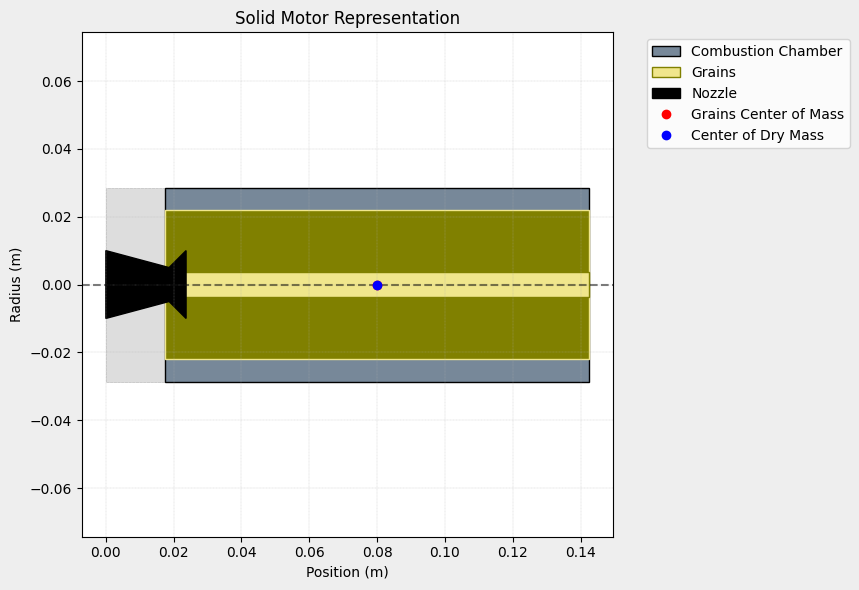

In [57]:
m300.plots.draw()

Nozzle Details
Nozzle Radius: 0.01 m
Nozzle Throat Radius: 0.005 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 1730 kg/m3
Grain Outer Radius: 0.022 m
Grain Inner Radius: 0.003625 m
Grain Height: 0.125 m
Grain Volume: 0.000 m3
Grain Mass: 0.320 kg

Motor Details
Total Burning Time: 1.8 s
Total Propellant Mass: 0.320 kg
Structural Mass Ratio: 0.607
Average Propellant Exhaust Velocity: 870.006 m/s
Average Thrust: 154.613 N
Maximum Thrust: 272.733 N at 0.25 s after ignition.
Total Impulse: 278.304 Ns



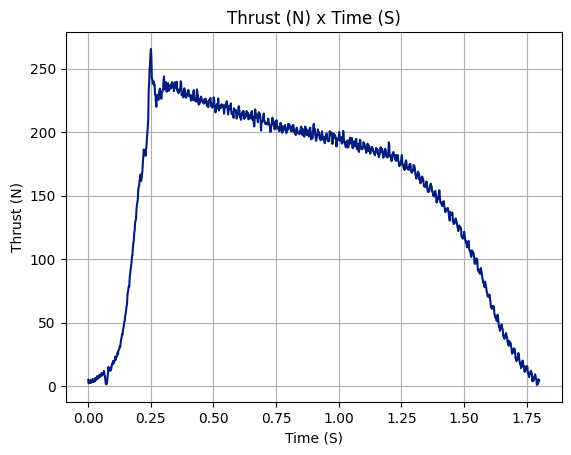

In [58]:
m300.info()

### Rocket


Create the `Rocket` object with the real dimensions


In [59]:
vetor_ii = Rocket(
    radius=0.065 / 2,
    mass=1.079,
    inertia=(
        0.1163,
        0.1163,
        0.0005,
    ),
    power_off_drag=0.43,
    power_on_drag=0.43,
    center_of_mass_without_motor=0,
)
vetor_ii.add_motor(motor=m300, position=-0.600)

Adding nose cone

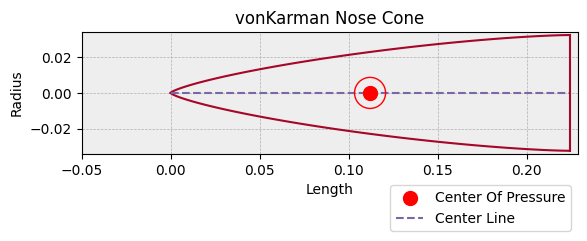

In [60]:
nose_cone = vetor_ii.add_nose(
    length=0.224,
    kind="vonKarman",
    position=0.314,
).draw()

Adding trapezoidal fins

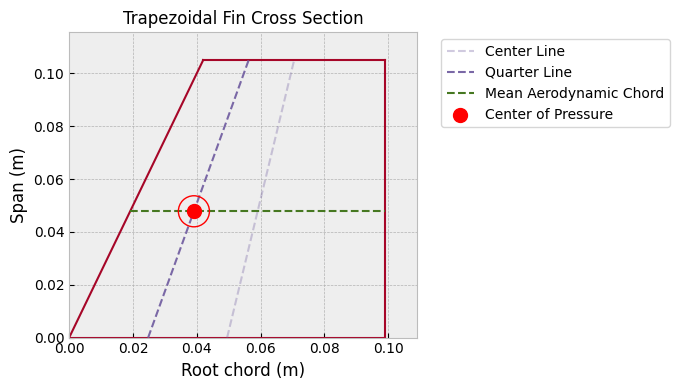

In [61]:
fin_set = vetor_ii.add_trapezoidal_fins(
    4,
    span=0.105,
    root_chord=0.099,
    tip_chord=0.057,
    position=-0.497,
).draw()

The parachute was not added as further studies within the Vetor II Project are needed to correctly model it.

In [62]:
vetor_ii.info()


Inertia Details

Rocket Mass: 1.079 kg (without motor)
Rocket Dry Mass: 1.573 kg (with unloaded motor)
Rocket Loaded Mass: 1.893 kg
Rocket Structural Mass Ratio: 0.831
Rocket Inertia (with unloaded motor) 11: 0.208 kg*m2
Rocket Inertia (with unloaded motor) 22: 0.208 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.001 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0325 m
Rocket Frontal Area: 0.003318 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.163 m
Rocket Center of Dry Mass - Nozzle Exit: 0.437 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.357 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.060 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 19.130/rad

Center of Pressure

Nose 

Rocket Representation and comparison with actual 3D model

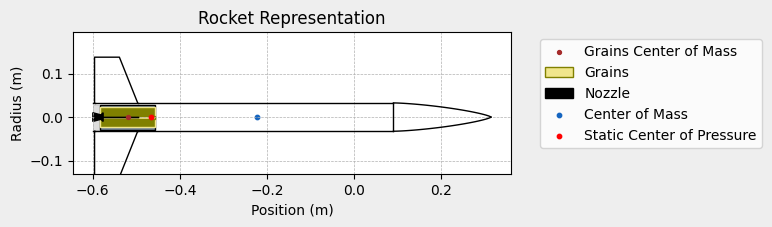

In [63]:
vetor_ii.draw()

![Vetor II's actual 3D Model on SolidWorks](../../data/rockets/vetor_ii/vetor_ii_3d_model.jpeg)

### Flight


In [64]:
# Flight
test_flight = Flight(rocket=vetor_ii, environment=env, rail_length=4)


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 580.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.704 | e1: -0.062 | e2: 0.062 | e3: -0.704
Euler Angles - Spin φ : 0.00° | Nutation θ: -10.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 3.733 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 4 m
Launch Rail Inclination: 80.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.447 s
Rail Departure Velocity: 30.139 m/s
Rail Departure Stability Margin: 3.916 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 12.713
Rail Departure Reynolds Number: 1.282e+05


Burn out State

Burn out time: 1.800 s
Altitude at burn out: 712.530 m (ASL) | 132.530 m (AGL)
Rocket speed at burn out: 137.107 m/s
Freestream velo

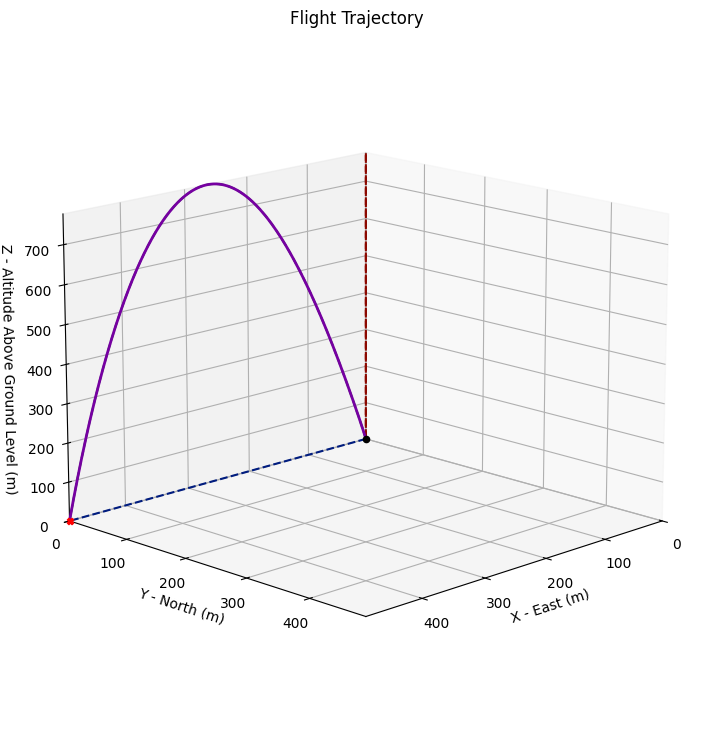

In [65]:
test_flight.info()
test_flight.plots.trajectory_3d()

## Comparison with the original one-dimensional simulator from Vetor II

The Vetor II Project featured its own one-dimensional simulator. While it does not provide spatial trajectory information or account for angle of attack, it allows for a comparison of absolute values of acceleration, velocity, and altitude over time.


**Note:** Several complexities of the Vetor II Project, such as the parachute and other parameters, were not considered, which could impact the differences between the results.


Load the one-dimensional simulator data


In [66]:
onedimensional_simulation = np.genfromtxt(
    "../../data/rockets/vetor_ii/vetor_ii_onedimensional_flight_simulation.csv",
    delimiter=",",
    skip_header=1,
)

onedimensional_simu_time = onedimensional_simulation[:, 0]
onedimensional_simu_acceleration = onedimensional_simulation[:, 1]
onedimensional_simu_velocity = onedimensional_simulation[:, 2]
onedimensional_simu_altitude = onedimensional_simulation[:, 3]

Convert to Function objects


In [67]:
onedimensional_az = Function(
    source=np.column_stack(
        (onedimensional_simu_time, onedimensional_simu_acceleration)
    ),
    inputs="Time (s)",
    outputs="Acceleration (m/s²)",
    interpolation="linear",
    extrapolation="zero",
)

onedimensional_vz = Function(
    source=np.column_stack((onedimensional_simu_time, onedimensional_simu_velocity)),
    inputs="Time (s)",
    outputs="Vertical velocity (m/s)",
    interpolation="linear",
    extrapolation="zero",
)

onedimensional_z = Function(
    source=np.column_stack((onedimensional_simu_time, onedimensional_simu_altitude)),
    inputs="Time (s)",
    outputs="Altitude above ground level (m)",
    interpolation="linear",
    extrapolation="zero",
)

Get the simulated results


In [68]:
simulated_z = test_flight.z - env.elevation
simulated_vz = test_flight.vz
simulated_az = test_flight.az
simulated_t_final = test_flight.t_final
simulated_apogee = test_flight.apogee - env.elevation

### Plots comparison


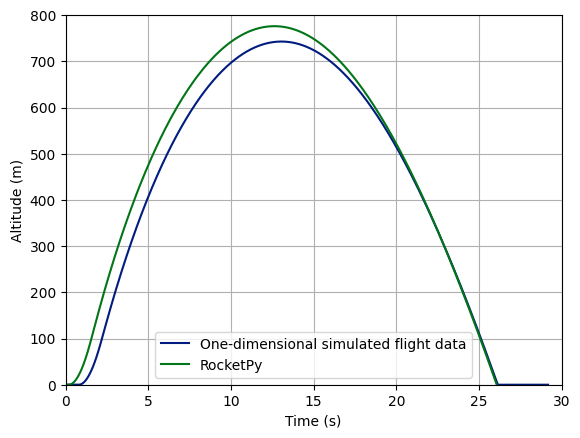

In [69]:
plt.plot(
    onedimensional_simu_time,
    onedimensional_simu_altitude,
    label="One-dimensional simulated flight data",
)
plt.plot(simulated_z[:, 0], simulated_z[:, 1], label="RocketPy")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.ylim(0, round(simulated_apogee, -2))
plt.xlim(0, round(simulated_t_final, -1))
plt.legend()
plt.grid()
plt.show()

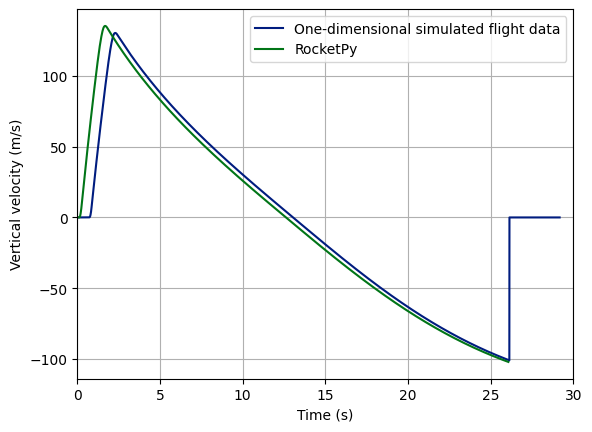

In [70]:
plt.plot(
    onedimensional_simu_time,
    onedimensional_simu_velocity,
    label="One-dimensional simulated flight data",
)
plt.plot(simulated_vz[:, 0], simulated_vz[:, 1], label="RocketPy")
plt.xlabel("Time (s)")
plt.ylabel("Vertical velocity (m/s)")
plt.xlim(0, round(simulated_t_final, -1))
plt.legend()
plt.grid()
plt.show()

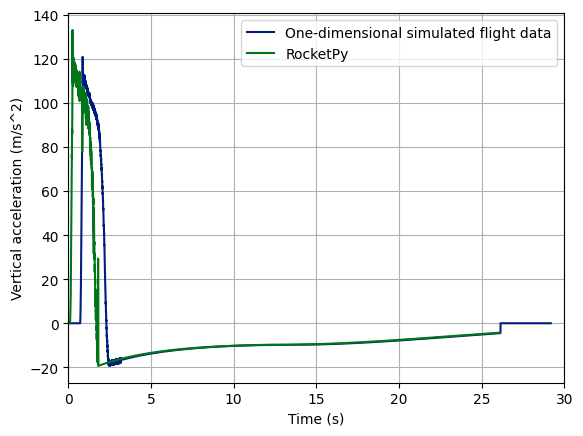

In [71]:
plt.plot(
    onedimensional_simu_time,
    onedimensional_simu_acceleration,
    label="One-dimensional simulated flight data",
)
plt.plot(simulated_az[:, 0], simulated_az[:, 1], label="RocketPy")
plt.xlabel("Time (s)")
plt.ylabel("Vertical acceleration (m/s^2)")
# plt.ylim()
plt.xlim(0, round(simulated_t_final, -1))
plt.legend()
plt.grid()
plt.show()

While the one-dimensional simulator from the Vetor II Project is much simpler and lacks many advanced features, such as Monte Carlo simulations and detailed aerodynamic modeling, it helps to reinforce the accuracy of RocketPy in predicting key flight metrics, since it is an external and independent validation source.